In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Block1: Setup Data

In [2]:
import pandas as pd
import re
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import mannwhitneyu
from itertools import combinations
import warnings

# Define the file path
file_path = "/content/drive/MyDrive/CYON_Analysis_Materials/Main_Test/Final_Cleaned_Dec18.csv"

# Read the CSV file into DataFrame df1
try:
    df1 = pd.read_csv(file_path)
    print("File loaded successfully.")
    print("First 5 rows of your data:")
    print(df1.head())
    print("\nDataFrame Info:")
    df1.info()

    # ------------------------------------------------------------------
    # Remove fixed introductory sentences from generatedBody
    # ------------------------------------------------------------------
    prefix = (
        "The Trump administration announced the U.S. withdrawal from the Paris Agreement in January 2025. "
        "This decision comes with far-reaching implications."
    )

    df1["ed_generatedBody"] = (
        df1["generatedBody"]
        .str.replace(prefix, "", regex=False)
        .str.lstrip()
    )

    print("\nText cleaning completed. 'ed_generatedBody' column created.")

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    print("Please check the file path and try again.")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")

File loaded successfully.
First 5 rows of your data:
   Progress  Duration__in_seconds_  ICF  DEM1  DEM1_5_TEXT  DEM2  DEM3  DEM4  \
0     100.0                  386.0    1     2          NaN  42.0     6     6   
1     100.0                  546.0    1     1          NaN  59.0     6     6   
2     100.0                  581.0    1     2          NaN  43.0     3     4   
3     100.0                  627.0    1     2          NaN  71.0     7     8   
4     100.0                  775.0    1     1          NaN  63.0     3     6   

   DEM5   DEM6  ...  CPS_P  CII_P  POP  CPP1  CPP2 CPP3  PSA  SA_re   PAS  \
0     1  18966  ...    1.0    1.0  0.0  0.13  0.33 -2.0  1.0   5.00  0.00   
1     1  27284  ...    0.0    0.0  0.0  0.00  0.00  0.0  0.0   5.00  1.00   
2     1  89015  ...    0.0    0.0  1.0  0.00  0.00  0.0  0.0   4.00  3.00   
3     1  83616  ...    1.0    0.0  1.0  0.00  0.67  0.0  0.0   5.00  4.00   
4     1  17543  ...    1.0    1.0  0.0  0.13  0.67  2.0  0.0   1.00  3.00   

   

Block 2: Generate Embeddings and Similarity MatrixThis is the most computationally expensive step. We encode all texts into SBERT vectors and then compute a single, large $N \times N$ similarity matrix, where $N$ is the total number of texts. We will reuse this matrix for all subsequent analyses.

In [3]:
# Load a pre-trained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

print("Encoding texts... This may take a while.")

# --- IMPORTANT ---
# Make sure 'ed_generatedBody' is the correct column name from Block 1's output!
try:
    texts = df1['ed_generatedBody'].tolist()
except KeyError:
    print("="*50)
    print("ERROR: Could not find column 'ed_generatedBody'.")
    print("Please check the column names printed in Block 1 and")
    print("update the 'texts = df1['...']' line in Block 2 with your correct text column.")
    print("="*50)
    # Stop execution by raising the error again
    raise

embeddings = model.encode(texts, show_progress_bar=True)
print("Embeddings generated. Shape:", embeddings.shape)

# Calculate the pairwise cosine similarity matrix for all texts
print("Calculating full similarity matrix...")
similarity_matrix = cosine_similarity(embeddings)
print("Similarity matrix shape:", similarity_matrix.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding texts... This may take a while.


Batches:   0%|          | 0/23 [00:00<?, ?it/s]

Embeddings generated. Shape: (711, 384)
Calculating full similarity matrix...
Similarity matrix shape: (711, 711)


Block 3: Define Reusable Analysis Function
This block defines the master function. You only need to run this block once to "teach" Python the function.

In [4]:
def perform_similarity_analysis(df, group_column_name, similarity_matrix):
    """
    Performs a 3-part similarity analysis on a dataframe
    for a specified grouping column.

    Args:
        df (pd.DataFrame): The dataframe containing the group labels.
        group_column_name (str): The name of the column to group by.
        similarity_matrix (np.array): The pre-computed N x N similarity matrix.
    """

    print("\n" + "#"*60)
    print(f"  RUNNING ANALYSIS FOR: '{group_column_name}'")
    print("#"*60)

    # Ensure the column exists
    if group_column_name not in df.columns:
        print(f"ERROR: Column '{group_column_name}' not found in DataFrame.")
        print("Skipping this analysis.")
        return

    # Make sure group values are non-null
    df_analysis = df[[group_column_name]].copy()
    df_analysis = df_analysis.dropna(subset=[group_column_name])

    groups = sorted(df_analysis[group_column_name].unique())
    print(f"Found {len(groups)} unique groups: {groups}")

    all_within_scores = {}
    within_group_results = {}

    # --- Part 1: Within-Group Similarity ---
    print("\n" + "="*30)
    print("Part 1: Within-Group Similarity")
    print("="*30)

    for group in groups:
        group_indices = df_analysis[df_analysis[group_column_name] == group].index.tolist()

        if len(group_indices) < 2:
            print(f"Group '{group}' has fewer than 2 items, skipping.")
            continue

        sub_matrix = similarity_matrix[np.ix_(group_indices, group_indices)]
        iu_indices = np.triu_indices_from(sub_matrix, k=1)
        within_scores = sub_matrix[iu_indices]

        if len(within_scores) > 0:
            all_within_scores[group] = within_scores
            mean_similarity = np.mean(within_scores)
            within_group_results[group] = mean_similarity
            print(f"  - Group '{group}' (N={len(group_indices)}): Avg Similarity = {mean_similarity:.4f}")
        else:
            print(f"  - Group '{group}' (N={len(group_indices)}): Not enough pairs for comparison.")

    # --- Part 2: Between-Group Similarity ---
    print("\n" + "="*30)
    print("Part 2: Between-Group Similarity (Difference)")
    print("="*30)

    between_group_results = {}
    for group1, group2 in combinations(groups, 2):
        group1_indices = df_analysis[df_analysis[group_column_name] == group1].index.tolist()
        group2_indices = df_analysis[df_analysis[group_column_name] == group2].index.tolist()

        if not group1_indices or not group2_indices:
            continue

        sub_matrix = similarity_matrix[np.ix_(group1_indices, group2_indices)]
        between_scores = sub_matrix.flatten()

        if len(between_scores) > 0:
            mean_similarity = np.mean(between_scores)
            pair_name = f"{group1} <-> {group2}"
            between_group_results[pair_name] = mean_similarity
            print(f"  - Pair '{pair_name}': Avg Similarity = {mean_similarity:.4f}")

    # --- Part 3: Statistical Significance ---
    print("\n" + "="*30)
    print("Part 3: Statistical Significance")
    print("="*30)

    stat_results = []

    # Suppress warnings from Mann-Whitney U test (e.g., ties)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        for group in groups:
            within_scores = all_within_scores.get(group)

            if within_scores is None or len(within_scores) == 0:
                print(f"  - Group '{group}': Skipping (no within-group pairs).")
                continue

            group_indices = df_analysis[df_analysis[group_column_name] == group].index.tolist()
            other_indices = df_analysis[df_analysis[group_column_name] != group].index.tolist()

            if not other_indices:
                print(f"  - Group '{group}': Skipping (no other groups to compare to).")
                continue

            sub_matrix = similarity_matrix[np.ix_(group_indices, other_indices)]
            between_scores = sub_matrix.flatten()

            if len(between_scores) == 0:
                print(f"  - Group '{group}': Skipping (no between-group pairs).")
                continue

            try:
                stat, p_value = mannwhitneyu(
                    within_scores,
                    between_scores,
                    alternative='greater'
                )

                mean_within = np.mean(within_scores)
                mean_between = np.mean(between_scores)

                stat_results.append({
                    'Group': group,
                    'Mean_Within_Sim': mean_within,
                    'Mean_Between_Sim': mean_between,
                    'U_Statistic': stat,
                    'p_value': p_value,
                    'Significant (p<0.05)': p_value < 0.05
                })

            except ValueError:
                 print(f"  - Group '{group}': Could not run test (e.g., zero variance).")

    if stat_results:
        df_stats = pd.DataFrame(stat_results)
        df_stats = df_stats.set_index('Group')
        print("\n--- Summary of Statistical Significance ---")
        print(df_stats.to_string(float_format="%.6f"))
    else:
        print("\nNo statistical results to display.")

    print("\n" + "#"*60)
    print(f"  ANALYSIS FOR '{group_column_name}' COMPLETE")
    print("#"*60 + "\n")

print("Reusable analysis function 'perform_similarity_analysis' is defined.")

Reusable analysis function 'perform_similarity_analysis' is defined.


Block 4: Analysis - Run for "DISP"
This block calls the same function on "Group" column.


In [5]:
# Run the complete analysis for the 'Group' column
perform_similarity_analysis(
    df=df1,
    group_column_name='DISP',
    similarity_matrix=similarity_matrix
)


############################################################
  RUNNING ANALYSIS FOR: 'DISP'
############################################################
Found 4 unique groups: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0)]

Part 1: Within-Group Similarity
  - Group '0.0' (N=178): Avg Similarity = 0.7836
  - Group '1.0' (N=175): Avg Similarity = 0.8508
  - Group '2.0' (N=179): Avg Similarity = 0.8275
  - Group '3.0' (N=179): Avg Similarity = 0.8258

Part 2: Between-Group Similarity (Difference)
  - Pair '0.0 <-> 1.0': Avg Similarity = 0.8004
  - Pair '0.0 <-> 2.0': Avg Similarity = 0.7736
  - Pair '0.0 <-> 3.0': Avg Similarity = 0.6873
  - Pair '1.0 <-> 2.0': Avg Similarity = 0.8174
  - Pair '1.0 <-> 3.0': Avg Similarity = 0.7155
  - Pair '2.0 <-> 3.0': Avg Similarity = 0.7085

Part 3: Statistical Significance

--- Summary of Statistical Significance ---
       Mean_Within_Sim  Mean_Between_Sim       U_Statistic  p_value  Significant (p<0.05)
Group                

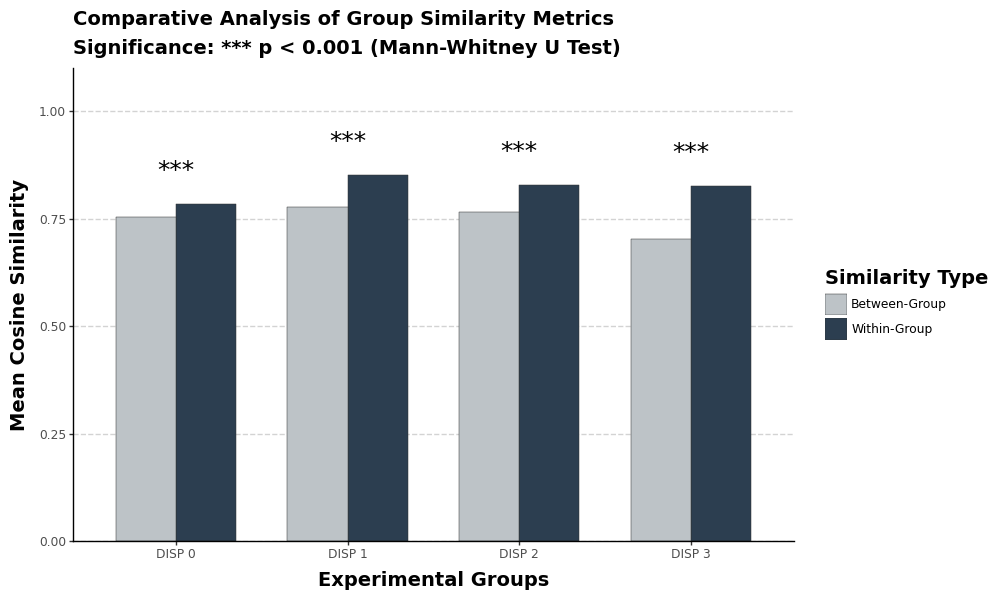

In [19]:
import pandas as pd
import numpy as np
from plotnine import *

# 1. Prepare the data from your summary table
data = {
    'Group': ['DISP 0', 'DISP 1', 'DISP 2', 'DISP 3'],
    'Mean_Within_Sim': [0.783628, 0.850774, 0.827533, 0.825771],
    'Mean_Between_Sim': [0.753403, 0.777711, 0.766096, 0.703685],
    'p_value': [0.000000, 0.000000, 0.000000, 0.000000]
}
df = pd.DataFrame(data)

# 2. Reshape data to 'long format'
df_melted = df.melt(
    id_vars=['Group', 'p_value'],
    value_vars=['Mean_Within_Sim', 'Mean_Between_Sim'],
    var_name='Metric',
    value_name='Similarity'
)

df_melted['Metric'] = df_melted['Metric'].replace({
    'Mean_Within_Sim': 'Within-Group',
    'Mean_Between_Sim': 'Between-Group'
})

# 3. Helper for significance annotations
df_stars = df.copy()
df_stars['label'] = '***'
# Place stars slightly above the highest bar in each group
df_stars['y_pos'] = df[['Mean_Within_Sim', 'Mean_Between_Sim']].max(axis=1) + 0.05

# 4. Construct and display the plot
# Wrapping the plot in parentheses and ensuring it's the last line triggers Colab's auto-render
plot = (
    ggplot(df_melted, aes(x='Group', y='Similarity', fill='Metric'))
    + geom_col(position='dodge', width=0.7, color="#333333", size=0.2)
    + geom_text(
        data=df_stars,
        mapping=aes(x='Group', y='y_pos', label='label'),
        inherit_aes=False,
        size=18,
        va='bottom'
    )
    + scale_fill_manual(values=["#BDC3C7", "#2C3E50"]) # Professional Grayscale/Navy
    + labs(
        title='Comparative Analysis of Group Similarity Metrics',
        subtitle='Significance: *** p < 0.001 (Mann-Whitney U Test)',
        x='Experimental Groups',
        y='Mean Cosine Similarity',
        fill='Similarity Type'
    )
    + scale_y_continuous(expand=(0, 0, 0.1, 0), limits=(0, 1.0))
    + theme_classic()
    + theme(
        figure_size=(10, 6),
        title=element_text(size=14, weight='bold'),
        legend_position='right',
        axis_line=element_line(size=1, color="black"),
        panel_grid_major_y=element_line(color="lightgrey", linetype="dashed")
    )
)

# This line ensures the plot is shown in Colab
plot.draw()